# Power/FDR comparisons on UKB genotypes

In [1]:
using CSV
using DataFrames
using DelimitedFiles

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number, 
        joblog_dir::String="/oak/stanford/groups/zihuai/solveblock/joblogs"; 
        jobname="submit", waitfor=Int[], verbose=true, highp=false)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        if highp
            println(io, "#SBATCH --time=168:00:00")
        else
            println(io, "#SBATCH --time=24:00:00")
        end
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        if highp
            println(io, "#SBATCH --partition=candes,zihuai")
        else
            println(io, "#SBATCH --partition=candes,zihuai,normal,owners")
        end
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.9.4")
#         println(io, "module load R/4.0.2")
#         println(io, "module load biology plink/1.90b5.3")
#         println(io, "export OPENBLAS_NUM_THREADS=1")
#         println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && print(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, total_mem::Number, 
        joblog_dir::String="/oak/stanford/groups/zihuai/solveblock/joblogs"; 
        jobname="submit", waitfor=Int[], verbose=true, highp=false)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        if highp
            println(io, "#SBATCH --time=168:00:00")
        else
            println(io, "#SBATCH --time=24:00:00")
        end
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        if highp
            println(io, "#SBATCH --partition=candes,zihuai")
        else
            println(io, "#SBATCH --partition=candes,zihuai,normal,owners")
        end
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.9.4")
#         println(io, "module load R/4.0.2")
#         println(io, "module load biology plink/1.90b5.3")
#         println(io, "export OPENBLAS_NUM_THREADS=1")
#         println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && print(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end


"Run a Cmd object, returning the stdout & stderr contents plus the exit code"
function execute(cmd::Cmd)
    out = Pipe()
    err = Pipe()

    process = run(pipeline(ignorestatus(cmd), stdout=out, stderr=err))
    close(out.in)
    close(err.in)

    return (
        stdout = String(read(out)), 
        stderr = String(read(err)),  
        code = process.exitcode
    )
end

function get_job_names()
    data_str, _, _ = execute(`squeue -u bbchu -h -o "%.30j"`)
    lines = split(data_str, "\n")
    jobnames = String[]
    for line in lines
        push!(jobnames, strip(line))
    end
    return jobnames
end

get_job_names (generic function with 1 method)

## Data QC


```shell
# filter for maf > 0.01
cd /oak/stanford/groups/zihuai/solveblock/array
/home/users/bbchu/plink/plink --bfile ukb_gen_british --maf 0.01 --make-bed --out ukb_gen_british_maf0.01

# filter by chr
for chr in {1..22}; do
    /home/users/bbchu/plink/plink --bfile ukb_gen_british_maf0.01 --chr $chr --make-bed --out ukb_gen_british_maf0.01_chr${chr}
done

# filter to 10k samples
head -10000 ukb_gen_british.fam | awk '{print $1, $2}' > first_10000_samples.txt
for chr in {1..22}; do
    /home/users/bbchu/plink/plink --bfile ukb_gen_british_maf0.01_chr${chr} --keep first_10000_samples.txt --make-bed --out ukb_gen_british_maf0.01_chr${chr}_10ksubset
done
```

## Run analysis

This notebook: 
+ Reads genotypes from "/oak/stanford/groups/zihuai/solveblock/array/ukb_gen_british.bed"
+ Regresses out the effect of covariates:
    - sex
    - age
    - age^2
    - sex*age
    - sex*age^2
    - top 10 PC
+ Simulates phenotypes $y$ from a linear model
+ Computes the score statistic $Z = \frac{1}{\sqrt{N}}X'y$
+ Plugs the resulting Z scores into ghostknockoff pipeline

In [ ]:
# put in script /oak/stanford/groups/zihuai/solveblock/fdr_sim.jl

using SnpArrays, Random, CSV, DataFrames, Distributions, StatsBase, GhostKnockoffGWAS
# LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files_ldetect" # based on LDetect output (doesn't control FDR)
# LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files_entire_chr" # works
# LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files_ld_split/min_error" # works
LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files_ld_split/default"
datadir = "/oak/stanford/groups/zihuai/solveblock/array"
covfile = "/oak/stanford/groups/zihuai/solveblock/covariates.csv"
chr = 22
hg_build = 19
seed = parse(Int, ARGS[1])
# seed = 123

# some helper functions
function pval2zscore(pvals::AbstractVector{T}, beta::AbstractVector{T}) where T
    length(pvals) == length(beta) || 
        error("pval2zscore: pvals and beta should have the same length")
    return zscore.(pvals, beta)
end
zscore(p::T, beta::T) where T = sign(beta) * quantile(Normal(), p/2)
pval(z::T) where T = 2ccdf(Normal(), abs(z))

# simulation parameters (beta ~ N(mu, sigma))
k = 10
mu = 0
sigma = 0.5

# read covariates
covar = CSV.read(covfile, DataFrame)
C = Matrix(covar[1:10000, 2:end])

# import genotypes
xdata = SnpData(joinpath(datadir, "ukb_gen_british_maf0.01_chr$(chr)_10ksubset"))
X = SnpLinAlg{Float64}(xdata.snparray, center=true, scale=true, impute=true)
n, p = size(X)
X_pos = xdata.snp_info.position

# simulate causal beta
Random.seed!(seed)
beta = zeros(p)
for i in 1:k
    beta[i] = rand(Normal(mu, sigma))
end
shuffle!(beta)
causal_snps = findall(!iszero, beta)

# simulate phenotypes, regress out effect of covariates, and normalize it
Random.seed!(seed)
eta = X*beta
y_raw = eta + rand(Normal(0, 3), n)
y = y_raw - C*inv(C'*C)*(C'*y_raw)
zscore!(y, mean(y), std(y))
heritability = var(eta) / var(y_raw)
@show heritability

# marginal association test: Z scores and associated p-values
z = X'*y ./ sqrt(n)
pvals = pval.(z)

# run GhostKnockoffGWAS on output of `solveblock`
chrs = parse.(Int, xdata.snp_info.chromosome)
pos = xdata.snp_info.position
ref = xdata.snp_info.allele1
alt = xdata.snp_info.allele2
outdir = "/oak/stanford/groups/zihuai/solveblock/sims"
outname = "sim$seed"
total_time = @elapsed GhostKnockoffGWAS.ghostknockoffgwas(
    LD_files, z, chrs, pos, Vector(ref), Vector(alt), n, hg_build, outdir,
    outname = outname, random_shuffle=false, A_scaling_factor=0.01, kappa_lasso=0.6)

# save true beta vector into the GK output
outfile = joinpath(outdir, outname)
GK_df = CSV.read(outfile * ".txt", DataFrame)
GK_df[!, "true_beta"] = beta[indexin(GK_df[!, "pos_hg$(hg_build)"], X_pos)]
CSV.write(outfile * ".txt", GK_df)

# group power/fdr
GK_groups = GK_df[!, "group"]
GK_discover_groups = GK_groups[findall(isone, GK_df[!, "selected_fdr0.1"])]
causal_groups = unique!(GK_groups[findall(!iszero, GK_df.true_beta)])
GK_group_power = length(intersect(GK_discover_groups, causal_groups)) / length(causal_groups)
GK_group_FP = length(setdiff(GK_discover_groups, causal_groups))
GK_group_FDR = GK_group_FP / max(1, length(GK_discover_groups))
println("GK (group) power = $GK_group_power")
println("GK (group) FDR = $GK_group_FDR")

println("\nDone!")

Submit jobs

In [2]:
# chr22:
# 1-200 is N(0, 0.5)
exe = "/oak/stanford/groups/zihuai/solveblock/fdr_sim.jl"
for seed in 1:200
    submit("julia $exe $seed", 1, 24, jobname=seed)
end

Submitted batch job 58272021
Submitted batch job 58272023
Submitted batch job 58272024
Submitted batch job 58272025
Submitted batch job 58272027
Submitted batch job 58272029
Submitted batch job 58272031
Submitted batch job 58272032
Submitted batch job 58272033
Submitted batch job 58272034
Submitted batch job 58272035
Submitted batch job 58272036
Submitted batch job 58272037
Submitted batch job 58272038
Submitted batch job 58272039
Submitted batch job 58272040
Submitted batch job 58272041
Submitted batch job 58272043
Submitted batch job 58272044
Submitted batch job 58272045
Submitted batch job 58272046
Submitted batch job 58272047
Submitted batch job 58272048
Submitted batch job 58272049
Submitted batch job 58272050
Submitted batch job 58272051
Submitted batch job 58272052
Submitted batch job 58272053
Submitted batch job 58272054
Submitted batch job 58272055
Submitted batch job 58272056
Submitted batch job 58272057
Submitted batch job 58272058
Submitted batch job 58272059
Submitted batc

## Power vs FDR plot

In [4]:
using Plots
using ProgressMeter

global titlefontsize=10
global legendfontsize=10
global labelfontsize=10
global annotationfontsize=10
global guidefontsize=10

function make_plot(power::Vector{Float64}, obs_fdr::Vector{Float64}, tgt_fdr::Vector{Float64})
    power_plt = plot(tgt_fdr, power; xtick=false, ylim=(0, 1.0), ylabel="Power",
        legend=false, left_margin = 5Plots.mm, titlefontsize=titlefontsize,
        guidefontsize=guidefontsize, labelfontsize=labelfontsize, w=3)
    fdr_plt = plot(tgt_fdr, obs_fdr; xlabel="target FDR", ylim=(0, 0.25), ylabel="obs FDR", legend=false, 
        xgrid=false, left_margin = 5Plots.mm, guidefontsize=guidefontsize,
        labelfontsize=labelfontsize, w=3)
    Plots.abline!(fdr_plt, 1, 0, alpha=0.3, w=2, linestyle=:dot, color=:black)
    return plot(power_plt, fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]), fmt=:png)
end

function summarize_result(seeds, tgt_fdr::Vector{Float64})
    powers = zeros(length(tgt_fdr))
    fdr = zeros(length(tgt_fdr))
    successes = 0
    @showprogress for seed in seeds
        try
            GK_df = CSV.read("/oak/stanford/groups/zihuai/solveblock/sims/sim$seed.txt", DataFrame)
            qvals = GK_df[!, "qvals"]
            beta = GK_df[!, "true_beta"]
            GK_groups = GK_df[!, "group"]
            causal_groups = unique!(GK_groups[findall(!iszero, beta)])
            for (i, threshold) in enumerate(tgt_fdr)
                GK_discover_snps = findall(x -> x < threshold, qvals)
                GK_discover_groups = unique!(GK_groups[GK_discover_snps])
                GK_group_power = length(intersect(GK_discover_groups, causal_groups)) / length(causal_groups)
                GK_group_FDR = length(setdiff(GK_discover_groups, causal_groups)) / max(1, length(GK_discover_groups))

                powers[i] += GK_group_power
                fdr[i] += GK_group_FDR
            end
            successes += 1
        catch
            continue
        end
    end
    @show successes
    powers ./= successes
    fdr ./= successes
    return powers, fdr
end

function summarize_regular_groupko_result(seeds, tgt_fdr::Vector{Float64})
    powers = zeros(length(tgt_fdr))
    fdr = zeros(length(tgt_fdr))
    successes = 0
    @showprogress for seed in seeds
        try
            GK_df = CSV.read("/oak/stanford/groups/zihuai/solveblock/sims/sim$seed.txt", DataFrame)
            beta = GK_df[!, "true_beta"]
            GK_groups = GK_df[!, "group"]
            causal_groups = unique!(GK_groups[findall(!iszero, beta)])
            for (i, threshold) in enumerate(tgt_fdr)
                GK_discover_snps = findall(isone, GK_df[!, "selected_fdr$threshold"])
                GK_discover_groups = unique!(GK_groups[GK_discover_snps])
                GK_group_power = length(intersect(GK_discover_groups, causal_groups)) / length(causal_groups)
                GK_group_FDR = length(setdiff(GK_discover_groups, causal_groups)) / max(1, length(GK_discover_groups))

                powers[i] += GK_group_power
                fdr[i] += GK_group_FDR
            end
            successes += 1
        catch
            continue
        end
    end
    @show successes
    powers ./= successes
    fdr ./= successes
    return powers, fdr
end

summarize_regular_groupko_result (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


successes = 200


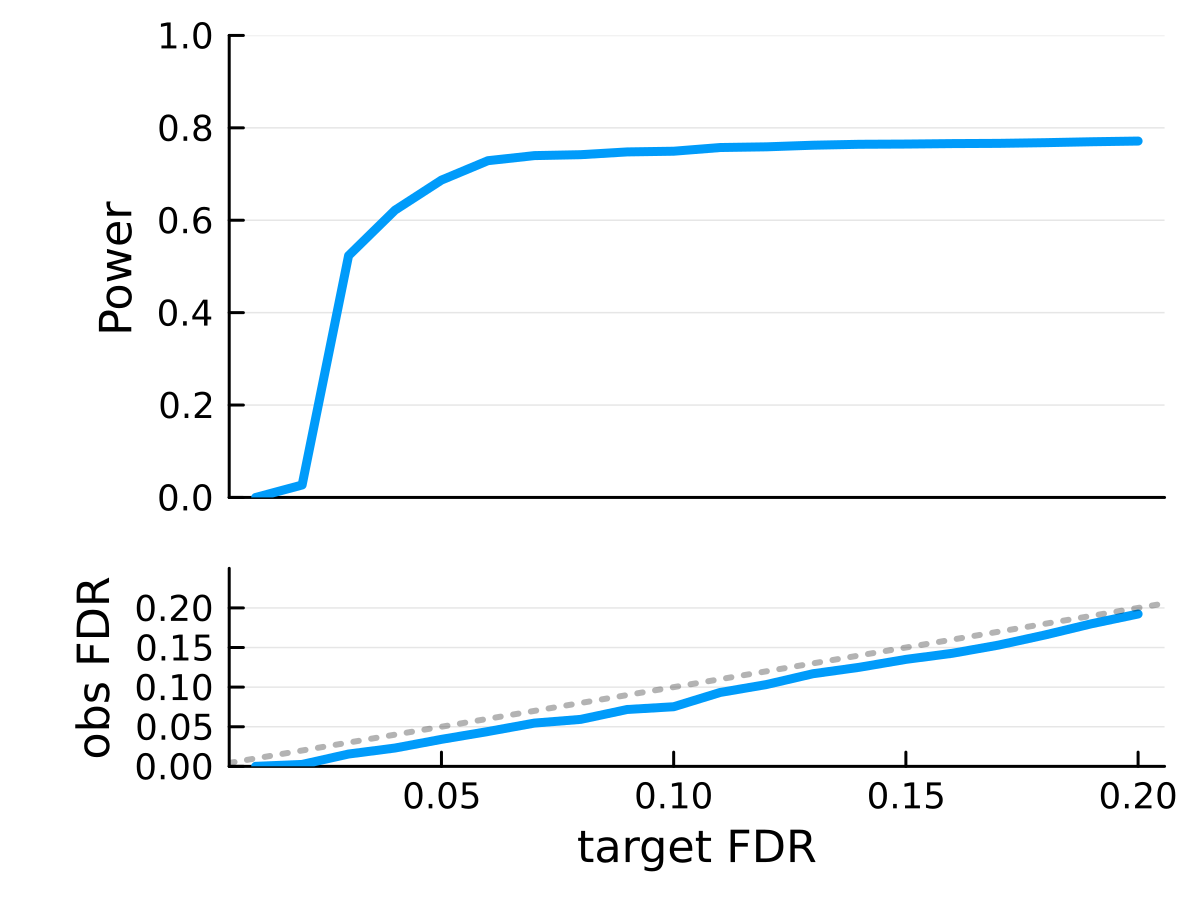

In [5]:
# beta ~ N(0, 0.5)
sims = 1:200
target_fdr = collect(0.01:0.01:0.2)
power, fdr = summarize_result(sims, target_fdr)
plt = make_plot(power, fdr, target_fdr)
plot(plt, dpi=300, size=(400, 300))

# BELOW ARE OLD RESULTS

Using either:
1. LDetect blocks (doesn't work)
2. snp_ldsplit but running using `min_error` objective (i.e. block sizes tend to be too large)

## Chr 22

This uses quasi-independent blocks from LDetect

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


successes = 200


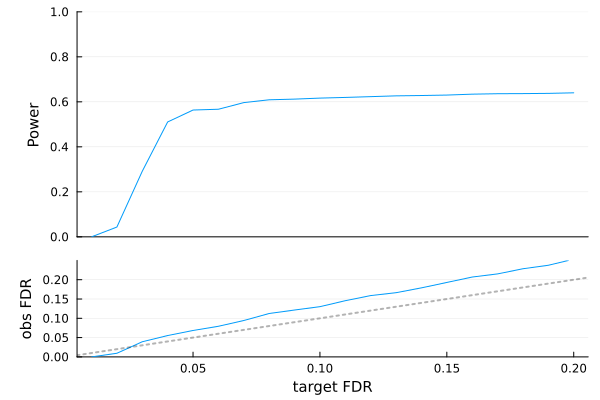

In [23]:
# beta ~ N(0, 0.3)   (regular group knockoff filter)
sims = 1:200
target_fdr = collect(0.01:0.01:0.2)
power, fdr = summarize_regular_groupko_result(sims, target_fdr)
plt = make_plot(power, fdr, target_fdr)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


successes = 165


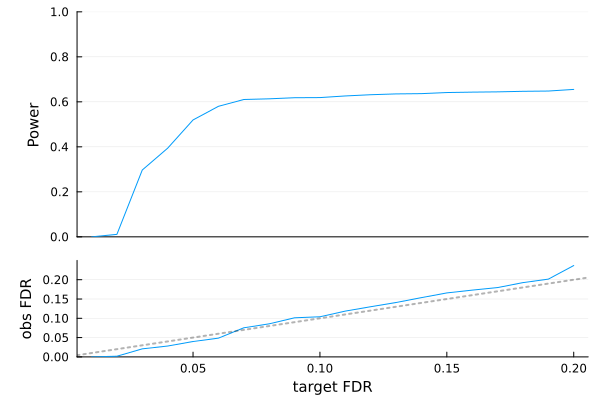

In [22]:
# beta ~ N(0, 0.3)      (within-group knockoff filter)
sims = 201:400
target_fdr = collect(0.01:0.01:0.2)
power, fdr = summarize_result(sims, target_fdr)
plt = make_plot(power, fdr, target_fdr)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:30


successes = 200


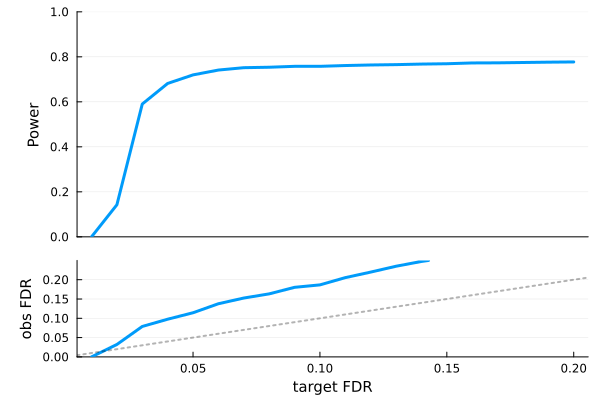

In [25]:
# beta ~ N(0, 0.5)      (within-group knockoff filter)
sims = 401:600
target_fdr = collect(0.01:0.01:0.2)
power, fdr = summarize_result(sims, target_fdr)
plt = make_plot(power, fdr, target_fdr)

This treats entire chr22 as 1 block

Progress: 100%|█████████████████████████████████████████| Time: 0:02:35


successes = 200


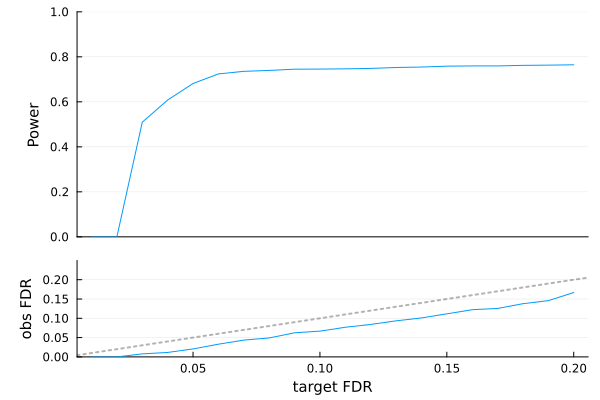

In [28]:
# beta ~ N(0, 0.5)
sims = 601:800
target_fdr = collect(0.01:0.01:0.2)
power, fdr = summarize_result(sims, target_fdr)
plt = make_plot(power, fdr, target_fdr)

This runs `snp_ldsplit` on chr22

Progress: 100%|█████████████████████████████████████████| Time: 0:03:30


successes = 200


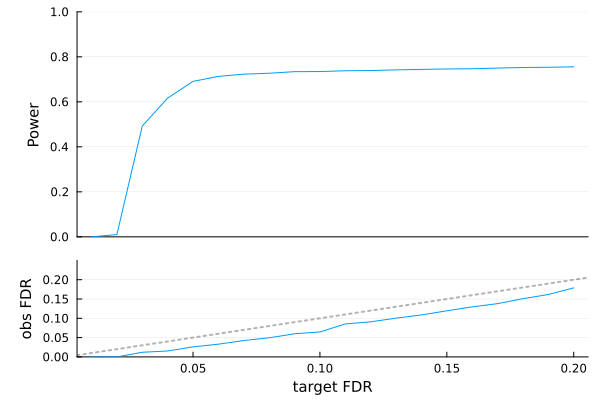

In [4]:
# beta ~ N(0, 0.5)
sims = 801:1000
target_fdr = collect(0.01:0.01:0.2)
power, fdr = summarize_result(sims, target_fdr)
plt = make_plot(power, fdr, target_fdr)

This runs `snp_ldsplit` on chr22 AND uniformly chooses causal beta randomlym

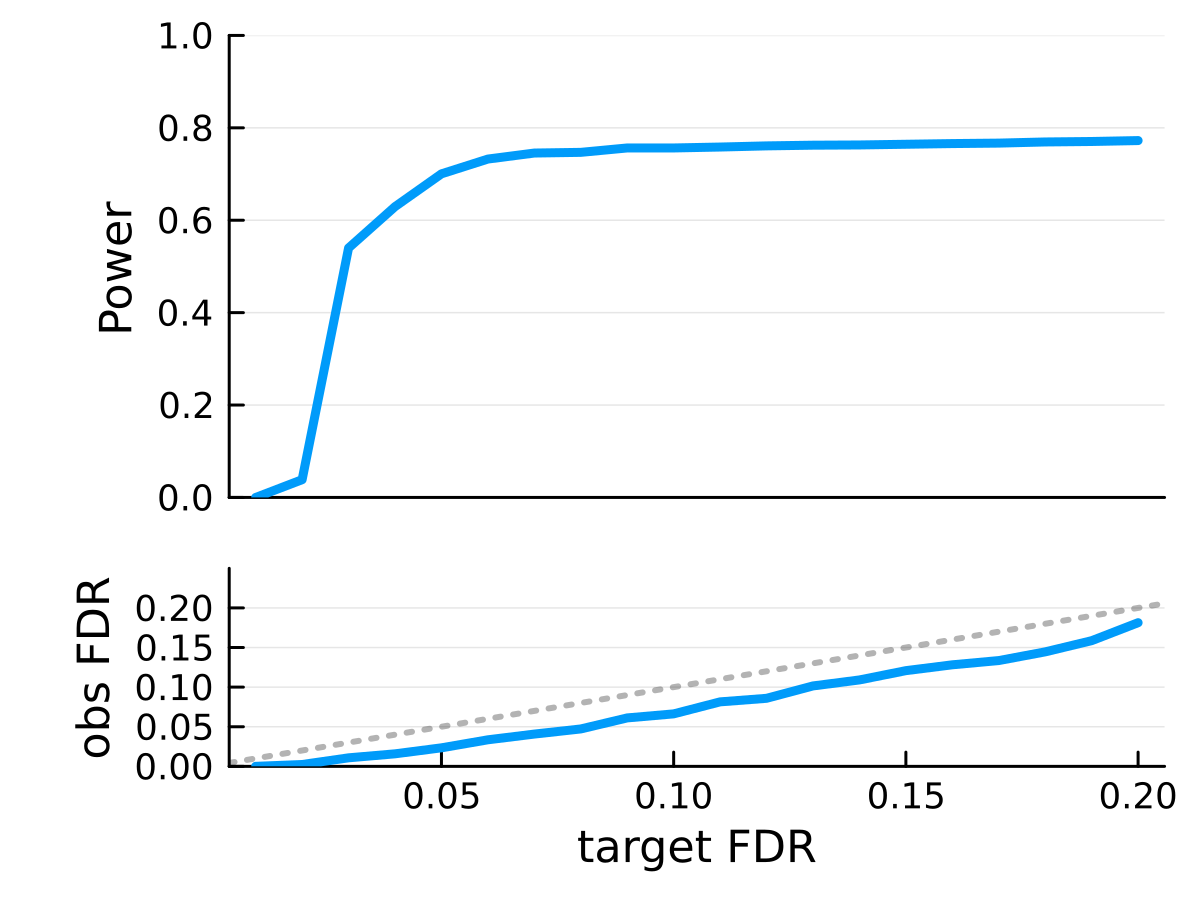

In [11]:
# beta ~ N(0, 0.5)
sims = 1001:1200
target_fdr = collect(0.01:0.01:0.2)
power, fdr = summarize_result(sims, target_fdr)
plt = make_plot(power, fdr, target_fdr)
plot(plt, dpi=300, size=(400, 300))

## Investigate FDR inflation



In [45]:
using SnpArrays, Statistics, ProgressMeter, CSV, DataFrames

function summarize_false_positives(seed, start_pos, end_pos)
    datadir = "/oak/stanford/groups/zihuai/solveblock/array"
    datafile = joinpath(datadir, "ukb_gen_british_maf0.01_chr22.bed")
    outdir = "/oak/stanford/groups/zihuai/solveblock/sims"
    outfile = joinpath(outdir, "sim$seed.txt")

    # read data and GK output
    x = SnpArray(datafile)
    GK_df = CSV.read(outfile, DataFrame)
    beta = GK_df[!, "true_beta"]
    qvals = GK_df[!, "qvals"]
    beta = GK_df[!, "true_beta"]
    GK_groups = GK_df[!, "group"]
    causal_snps = findall(!iszero, beta)
    causal_groups = unique!(GK_groups[causal_snps])

    # find all SNPs that are in causal group
    snps_in_causal_groups = Int[]
    for snp in causal_snps
        group = GK_groups[snp]
        append!(snps_in_causal_groups, findall(x -> x == group, GK_groups))
    end

    # discoveries (target fdr 10%)
    threshold = 0.1
    GK_discover_snps = findall(x -> x < threshold, qvals)
    GK_discover_groups = unique!(GK_groups[GK_discover_snps])
    GK_group_power = length(intersect(GK_discover_groups, causal_groups)) / length(causal_groups)
    GK_group_FDR = length(setdiff(GK_discover_groups, causal_groups)) / max(1, length(GK_discover_groups))

    # are false positives near causal ones?
    is_false_positive = falses(length(GK_discover_snps))
    max_corr = zeros(length(GK_discover_snps))
    for (i, snp) in enumerate(GK_discover_snps)
        group = GK_groups[snp]
        if group ∉ causal_groups
            x_subset = convert(Matrix{Float64}, @view(x[:, vcat(snp, snps_in_causal_groups)]), impute=true, center=true, scale=true)
            xcor = cor(x_subset)
            is_false_positive[i] = true
            max_corr[i] = argmax(abs, xcor[2:end, 1])
        end
    end

    # are discoveries near edge of block?
    mb_to_nearest_edge = zeros(Int, length(GK_discover_snps))
    for (i, snp) in enumerate(GK_discover_snps)
        snp_pos = GK_df.pos_hg19[snp]
        min_dist = min(abs(argmin(abs, end_pos .- snp_pos)), abs(argmin(abs, start_pos .- snp_pos)))
        mb_to_nearest_edge[i] = min_dist
    end
    
    df = DataFrame(
        "sim" => [seed for i in 1:length(is_false_positive)],
        "is_false_positive" => is_false_positive,
        "max_corr" => max_corr,
        "mb_to_nearest_edge" => mb_to_nearest_edge
    )

    return df
end

function LDetect_start_and_stop_pos()
    region_file = "/oak/stanford/groups/zihuai/pan_ukb_LD_matrices/LD_block/EUR_hg19/fourier_ls-all.bed"
    region_df = CSV.read(region_file, DataFrame) # output of LDetect
    region_df = region_df[findall(x -> x == "chr22 ", region_df[!, 1]), :]
    start_pos, end_pos = region_df[!, " start "], region_df[!, " stop"]
    return start_pos, end_pos
end

function LD_split_start_and_stop_pos()
    region_file = "/oak/stanford/groups/zihuai/solveblock/LD_split/min_error/chr22.maf0.01.thr0.01.maxr0.3.bed"
    region_df = CSV.read(region_file, DataFrame)
    start_pos, end_pos = region_df[!, "start"], region_df[!, "stop"]
    return start_pos, end_pos
end

function summarize_all_seeds(seeds, start_pos, end_pos)
    df = DataFrame("sim"=>Int[],"is_false_positive" => Bool[],
        "max_corr" => Float64[],"mb_to_nearest_edge" => Int[])
    @showprogress for seed in seeds
        try
            append!(df, summarize_false_positives(seed, start_pos, end_pos))
        catch
            continue
        end
    end
    return df
end

summarize_all_seeds (generic function with 2 methods)

In [47]:
# 401-600 is N(0, 0.5)   (within-group ko filter)
seeds = 401:600
start_pos, end_pos = LDetect_start_and_stop_pos()
df = summarize_all_seeds(seeds, start_pos, end_pos)
df[findall(df.is_false_positive), :]

Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


Row,sim,is_false_positive,max_corr,mb_to_nearest_edge
,Int64,Bool,Float64,Int64
1,402,true,-0.213623,1164
2,402,true,-0.0991077,1861
3,402,true,-0.131999,12255
4,402,true,0.253584,44990
5,403,true,0.00323149,981409
6,405,true,0.00426617,337456
7,406,true,0.445734,8048
8,406,true,0.0066053,94700
9,406,true,0.00425846,550803


In [48]:
# 1001-1200 is N(0, 0.5)  (within-group ko filter + snp_ldsplit blocks)
seeds = 1001:1200
start_pos, end_pos = LD_split_start_and_stop_pos()
df = summarize_all_seeds(seeds, start_pos, end_pos)
df[findall(df.is_false_positive), :]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


Row,sim,is_false_positive,max_corr,mb_to_nearest_edge
,Int64,Bool,Float64,Int64
1,1002,true,-0.00281474,1715372
2,1009,true,-0.00676188,1112049
3,1009,true,-0.00543462,658561
4,1013,true,-0.00457027,8919759
5,1021,true,0.00899709,277795
6,1024,true,0.0056397,133464
7,1025,true,-0.0136029,36079
8,1025,true,0.225626,7647187
9,1029,true,0.00414888,4089931
